In [50]:
#libraries
import os
import cv2
import numpy as np

In [51]:
import pandas as pd

In [52]:
# # Function to draw a box around a centroid on an image and return the coordinates
# def bonding_box(centroid):
#     # Calculate the top-left and bottom-right coordinates of the box
#     # top_left = (int(centroid[0] - box_size[0] / 2), int(centroid[1] - box_size[1] / 2))
#     # bottom_right = (int(centroid[0] + box_size[0] / 2), int(centroid[1] + box_size[1] / 2))
#     top_left = [int(centroid[0]) - 20, int(centroid[1])-35]
#     bottom_right = [int(centroid[0] + 20), int(centroid[1] + 45)]
#     if bottom_right[0] > 95:
#         bottom_right[0]=95
#     if bottom_right[1] > 95:
#         bottom_right[1]=95
#     if top_left[0] <0:
#         top_left[0] = 0
#     if top_left[1]<0 :
#        top_left[1] = 0
#     return top_left, bottom_right

In [53]:
# def bonding_box(centroid):
#     # Calculate the top-left and bottom-right coordinates of the box
#     # top_left = (int(centroid[0] - box_size[0] / 2), int(centroid[1] - box_size[1] / 2))
#     # bottom_right = (int(centroid[0] + box_size[0] / 2), int(centroid[1] + box_size[1] / 2))
#     top_left = [int(centroid[0]) - 20, int(centroid[1])-55]
#     bottom_right = [int(centroid[0] + 20), int(centroid[1] + 55)]
#     if bottom_right[0] > 120:
#         bottom_right[0]=120
#     if bottom_right[1] > 120:
#         bottom_right[1]=120
#     if top_left[0] <0:
#         top_left[0] = 0
#     if top_left[1]<0 :
#        top_left[1] = 0
#     return top_left, bottom_right

In [54]:
def bonding_box(centroid):
    # Calculate the top-left and bottom-right coordinates of the box
    # top_left = (int(centroid[0] - box_size[0] / 2), int(centroid[1] - box_size[1] / 2))
    # bottom_right = (int(centroid[0] + box_size[0] / 2), int(centroid[1] + box_size[1] / 2))
    top_left = [int(centroid[0]) - 20, int(centroid[1])-75]
    bottom_right = [int(centroid[0] + 20), int(centroid[1] + 75)]
    if bottom_right[0] > 160:
        bottom_right[0]=160
    if bottom_right[1] > 160:
        bottom_right[1]=160
    if top_left[0] <0:
        top_left[0] = 0
    if top_left[1]<0 :
       top_left[1] = 0
    return top_left, bottom_right

In [55]:
df = pd.read_excel("/content/ondevice_normal.xlsx")

In [56]:
df['confidence_score'] = df['confidence_score'].fillna(0)

In [57]:
df = df.fillna("[0,0]")

In [58]:
import ast

In [59]:
df["p_centriod"] = df["p_centriod"].apply(ast.literal_eval)

In [60]:
p_left_top = []
p_right_bottom = []

In [61]:
for index, row in df.iterrows():
  if(row["p_human"]==1):
    # print(row["p_centriod"])
    top_left, bottom_right = bonding_box(row["p_centriod"])
    p_right_bottom.append(bottom_right)
    p_left_top.append(top_left)
  else:
    p_right_bottom.append([0,0])
    p_left_top.append([0,0])

In [62]:
df["p_left_top"] = p_left_top
df["p_right_bottom"] = p_right_bottom

In [63]:
df["g_left_top"] = df["g_left_top"].apply(ast.literal_eval)
df["g_right_bottom"] = df["g_right_bottom"].apply(ast.literal_eval)

In [64]:
pip install torchmetrics

In [65]:
import torch
from torchmetrics.detection import IntersectionOverUnion

In [66]:
iou = []

In [67]:
for index, row in df.iterrows():
  if(row["g_human"]==1) & (row["p_human"]==1):
    preds = [
    {
        "boxes": torch.tensor([
              [row["g_left_top"][0] , row["g_left_top"][1], row["g_right_bottom"][0], row["g_right_bottom"][1]]]),
        "labels": torch.tensor([1]),
    }
    ]
    target = [
      {
          "boxes": torch.tensor([ [row["p_left_top"][0] , row["p_left_top"][1], row["p_right_bottom"][0], row["p_right_bottom"][1]]]),
          "labels": torch.tensor([1]),
      }
     ]
    metric = IntersectionOverUnion()
    iou_value = metric(preds, target)
    iou.append(iou_value['iou'])
  else:
    iou.append(0)

In [68]:
df['IOU'] = iou

In [69]:
# df.to_csv("device_normal_casev89.csv")

In [70]:
df_sorted = df.sort_values(by='confidence_score', ascending=False)

In [71]:
preds =0
golds = 0

In [72]:
preds = df_sorted["p_human"].sum()
golds = df_sorted["g_human"].sum()

In [73]:
tps = []
fps = []

In [74]:
for index, row in df_sorted.iterrows():
    #print(row['ground_truth'], row['predicted'])
    if (row['IOU']>0.1):
      tps.append(1)
      fps.append(0)
    else:
      tps.append(0)
      fps.append(1)

In [75]:
df_sorted["tps"] = tps
df_sorted["fps"] = fps

In [76]:
cumulative_fps = df_sorted["fps"].cumsum()
cumulative_tps = df_sorted["tps"].cumsum()

In [77]:
recalls_01 = np.divide(cumulative_tps, golds)
precisions_01 = np.divide(cumulative_tps, (cumulative_fps + cumulative_tps))

In [78]:
def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.

    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap

In [79]:
decreasing_max_precision_01 = np.maximum.accumulate(precisions_01[::-1])[::-1]

In [80]:
ap01 = compute_ap(recalls_01, decreasing_max_precision_01)

In [81]:
tps_025 = []
fps_025 = []

In [82]:
for index, row in df_sorted.iterrows():
    #print(row['ground_truth'], row['predicted'])
    if (row['IOU']>0.25):
      tps_025.append(1)
      fps_025.append(0)
    else:
      tps_025.append(0)
      fps_025.append(1)

In [83]:
df_sorted["tps_025"] = tps_025
df_sorted["fps_025"] = fps_025

In [84]:
cumulative_fps_025 = df_sorted["fps_025"].cumsum()
cumulative_tps_025 = df_sorted["tps_025"].cumsum()

In [85]:
recalls_025 = np.divide(cumulative_tps_025, golds)
precisions_025 = np.divide(cumulative_tps_025, (cumulative_fps_025 + cumulative_tps_025))

In [86]:
decreasing_max_precision_025 = np.maximum.accumulate(precisions_025[::-1])[::-1]

In [87]:
ap025 = compute_ap(recalls_025, decreasing_max_precision_025)

In [88]:
tps_05 = []
fps_05 = []

In [89]:
for index, row in df_sorted.iterrows():
    #print(row['ground_truth'], row['predicted'])
    if (row['IOU']>0.5):
      tps_05.append(1)
      fps_05.append(0)
    else:
      tps_05.append(0)
      fps_05.append(1)

In [90]:
df_sorted["tps_05"] = tps_05
df_sorted["fps_05"] = fps_05

In [91]:
cumulative_fps_05 = df_sorted["fps_05"].cumsum()
cumulative_tps_05 = df_sorted["tps_05"].cumsum()

In [92]:
recalls_05 = np.divide(cumulative_tps_05, golds)
precisions_05 = np.divide(cumulative_tps_05, (cumulative_fps_05 + cumulative_tps_05))

In [93]:
decreasing_max_precision_05 = np.maximum.accumulate(precisions_05[::-1])[::-1]

In [94]:
ap05 = compute_ap(recalls_05, decreasing_max_precision_05)

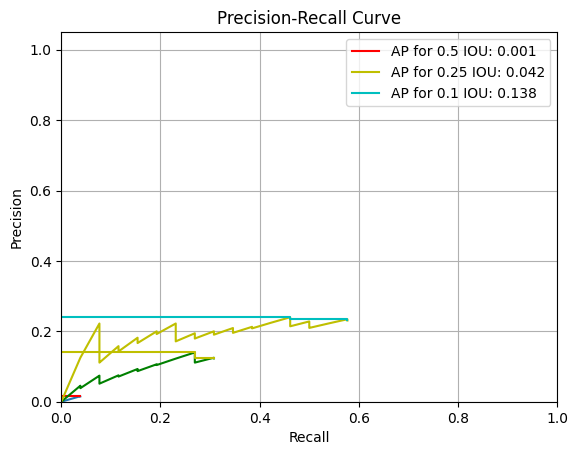

In [95]:
import matplotlib.pyplot as plt
plt.plot(recalls_05, precisions_05)
plt.step(recalls_05, decreasing_max_precision_05, '-r',label =f"AP for 0.5 IOU: {round(ap05,3)}")
plt.plot(recalls_025, precisions_025, '-g')
plt.step(recalls_025, decreasing_max_precision_025, '-y',label =f"AP for 0.25 IOU: {round(ap025,3)}")
plt.plot(recalls_01, precisions_01,'-y')
plt.step(recalls_01, decreasing_max_precision_01, '-c',label =f"AP for 0.1 IOU: {round(ap01,3)}")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
# plt.gca().spines['left'].set_visible(True)
plt.xlim(0, 1)
plt.ylim(0, 1.05)
plt.grid(True)
plt.legend()
plt.show()

with a detection model where you have per-image precision and recall values instead of binary labels,need to calculate the F1 score manually

In [96]:
import numpy as np

# Step 1: Calculate F1 score for each image
f1_scores_01 = [2 * (precisions_01 * recalls_01) / (precisions_01 + recalls_01) if (precisions_01 + recalls_01) != 0 else 0 for precisions_01, recalls_01 in zip(precisions_01, recalls_01)]

# Step 2: Average F1 scores across all images
overall_f1_score_01 = np.mean(f1_scores_01)

print("Overall F1 Score for IOU 0.1:", overall_f1_score_01)


Overall F1 Score for IOU 0.1: 0.19436794194545315


In [97]:
# Step 1: Calculate F1 score for each image
f1_scores_025 = [2 * (precisions_025 * recalls_025) / (precisions_025 + recalls_025) if (precisions_025 + recalls_025) != 0 else 0 for precisions_025, recalls_025 in zip(precisions_025, recalls_025)]

# Step 2: Average F1 scores across all images
overall_f1_score_025 = np.mean(f1_scores_025)

print("Overall F1 Score for IOU 0.25:", overall_f1_score_025)

Overall F1 Score for IOU 0.25: 0.07653808419609366


In [98]:
# Step 1: Calculate F1 score for each image
f1_scores_05 = [2 * (precisions_05 * recalls_05) / (precisions_05 + recalls_05) if (precisions_05 + recalls_05) != 0 else 0 for precisions_05, recalls_05 in zip(precisions_05, recalls_05)]

# Step 2: Average F1 scores across all images
overall_f1_score_05 = np.mean(f1_scores_05)

print("Overall F1 Score for IOU 0.5:", overall_f1_score_05)

Overall F1 Score for IOU 0.5: 0.0006800037569268339
